We want to create an initial set of template waveforms, one template being a three-component seismogram.

This is what we want to keep in mind to have for all three channels:
- Windows with both P- and S- pick
- Only one earthquake in the window
- Raw SNR > 2 for P-wave
- Raw SNR > 3 for S-wave
- Prioritize higher magnitudes first

To-do:
- For each earthquake, loop over all 3 channels and check P and S SNR in each
- If both SNRs are high enough for all 3 channels (6 checks), the event gets saved in a list

In [1]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client
import pyasdf

In [2]:
def read_files(base_folder):
    ''' Reads in earthquake catalog files from CSS format into useful pandas dataframes
    
        Inputs:
        base_folder = string containing name of year and month of interest, e.g. '2019_01'
        
        Outputs dataframes:
        assoc
        arrivals
        origin
    '''
    
    
    base_dir = 'catalog_css/'+base_folder+'/'
    
    arr_files = glob.glob(base_dir + 'catalog_XO_*arrival')
    assoc_files = glob.glob(base_dir + 'catalog_XO_*assoc')
    origin_files = glob.glob(base_dir + 'catalog_XO_*origin')
    
    # Read data into pandas dataframe
    arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
    assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
    origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

    # Rename some columns for clarity:
    assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
    origin = origin.rename(columns={4:'originid',3:'epochtime',20:'magnitude'})
    arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode", 1:'epochtime',7:'phase'})
    
    return(assoc,arrivals,origin)

In [3]:
def calc_snr(stream,sampleind,phase):
    # Calculate SNR of arrival
    # INPUTS:
    # stream = obspy-formatted waveform object
    # sampleind = index in the stream's data of desired arrival for which to calculate SNR
    # phase = type of arrival as a string, either 'P' or 'S'
    #
    # OUTPUT:
    # snr = float object of calculated SNR for the input index
    
    if phase == 'P':
        window = [5,5] # in seconds
    if phase == 'S':
        window = [5,5]
    try:
        data = stream[0].data
        sr = int(stream[0].stats.sampling_rate)
        snr_num = max(abs(data[sampleind:(sampleind+(window[0]*sr))]))
        snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))
        snr = snr_num/snr_denom
    except:
        snr = float('NaN')
    return(snr)

1551996729.29
2019-03-07 22:12:09.288390


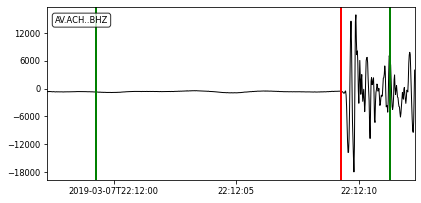

SNR = 25.4348632352


KeyboardInterrupt: Interrupted by user

In [7]:
# Load catalog info for one month
month = '2019_03'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

# Loop through events
for id in origin_ids:

    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']

    # Get list of stations that have both P and S pick
    repeats = []
    for station in stations:
        sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
        if len(np.unique(sub['phase']))>1:
            repeats.append(station)
   
    # Loop through P-wave picks
    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    repeat_subset = repeat_subset.drop_duplicates(subset=['stationcode'])
    repeat_subset.reset_index(drop=True,inplace=True)

    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        
        # Skip global array stations that have low sample rates and complicated location codes
        if len(pick['stationcode'])>3:
            continue
            
        # P arrival time:
        pick_epoch = pick['epochtime']
        print(pick_epoch)
        basetime = datetime.datetime.utcfromtimestamp(pick_epoch)
        print(basetime)
        
        # We want the streams for x minutes before and after the pick time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 2)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 10)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")

        # Download the streams INCLUDING the instrument response:
        channel_base = pick['channel'][0:2]
        # st = client.get_waveforms("XO,AK,AV",pick['stationcode'], "--",channel_base+'*', t1, t2,attach_response=True)
        st = client.get_waveforms("XO,AK,AV",pick['stationcode'], "--",channel_base+'Z', t1, t2,attach_response=True)  
    
        # Plot the raw waveform:
        %matplotlib inline
        fig = plt.figure()
        t11 = UTCDateTime(basetime)-datetime.timedelta(seconds = 12)
        t22 = UTCDateTime(basetime)+datetime.timedelta(seconds = 3)
        st.plot(fig = fig,starttime=t11,endtime=t22) 
        plt.axvline(x=UTCDateTime(basetime),linewidth=2, color='r')
        plt.axvline(x=UTCDateTime(basetime)-datetime.timedelta(seconds = 10),linewidth=2,color='g')
        plt.axvline(x=UTCDateTime(basetime)+datetime.timedelta(seconds = 2),linewidth=2,color='g')
        plt.show()
        # st.spectrogram(log=True, title=str(st[0].stats.starttime))
        
        # Calculate SNR of arrival
        sr = int(st[0].stats.sampling_rate)
        p_sampleind = ((2*60)*sr)-1 # index of sample that contains P pick
        snr = calc_snr(st,p_sampleind,'P')
        print('SNR = ' + str(snr))


        input("Press Enter to continue...")


Below:
Loops over earthquakes, then loops over stations with both a P and S pick for that earthquake, and checks for which ones have P and S picks with high SNR on all 3 channels of the stations

In [11]:
# Connect to asdf h5 file
ds = pyasdf.ASDFDataSet("test_file7.h5", compression="gzip-3")

# Load catalog info for one month
month = '2018_06'
ml_path = 'catalog_css/'+month+'/XO_'+month+'.quakeml'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

ev_count = -1
success=0
# Loop through events
for id in origin_ids:

    # Get magnitude for this earthquake
    ev_count += 1
    mag = origin.iloc[ev_count]['magnitude']
    
    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']

    # Get list of stations that have both P and S pick
    repeats = []
    for station in stations:
        sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
        if len(np.unique(sub['phase']))>1:
            repeats.append(station)
    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    repeat_subset = repeat_subset.drop_duplicates(subset=['stationcode'])
    repeat_subset.reset_index(drop=True,inplace=True)

    # Loop over stations
    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        station = pick['stationcode']
        p_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='P')]
        s_pick = arrival_subset.loc[(arrival_subset['stationcode']==station)&(arrival_subset['phase']=='S')]
        p_time = datetime.datetime.utcfromtimestamp(p_pick.iloc[0]['epochtime'])
        s_time = datetime.datetime.utcfromtimestamp(s_pick.iloc[0]['epochtime'])
        
        # We want the streams for 2 minutes before the P time and 10 minutes after the S time:
        t1 = UTCDateTime(p_time)-datetime.timedelta(minutes = 2)
        t2 = UTCDateTime(s_time)+datetime.timedelta(minutes = 10)
        channel_base = p_pick.iloc[0]['channel'][0:2]
        channels = [channel_base+'Z',channel_base+'E,'+channel_base+'1',channel_base+'N,'+channel_base+'2']

        
        # Loop over channels
        j = 0
        all_psnr = []
        all_ssnr = []
        while j < 3:
            # Now we query the data from IRIS for the time band defined above:
            client = Client("IRIS")

            # Only do OBS stations!!!
            try:
                st = client.get_waveforms("XO",station, "--",channels[j], t1, t2,attach_response=True)
            except:
                break
            
            # print(station)
            # print(channels[j])
            station_mda = client.get_stations(network="XO", station=station)
            elev = station_mda[0][0].elevation
            if elev > -10:
                break
            
            # Get index of the P and S pick
            nsamples = len(st[0].data)
            sr = int(st[0].stats.sampling_rate)
            p_sampleind = ((2*60)*sr)-1 # index of sample that contains P pick
            s_sampleind = nsamples - ((10*60)*sr) # index of sample that contains S pick
            
            # Calculate SNR of P and S pick
            p_snr = calc_snr(st,p_sampleind,'P')
            if p_snr < 2 or np.isnan(p_snr):
                break
            s_snr = calc_snr(st,s_sampleind,'S')
            if s_snr < 3 or np.isnan(s_snr):
                break
            print('P SNR = ' + str(p_snr))
            print('S SNR = ' + str(s_snr))
            all_psnr.append(p_snr)
            all_ssnr.append(s_snr)
            j += 1
            
#             %matplotlib inline
#             fig = plt.figure()
#             st.plot(fig = fig,starttime=t1,endtime=t2) 
#             plt.axvline(x=(p_time),linewidth=2, color='r')
#             plt.axvline(x=UTCDateTime(s_time),linewidth=2, color='g')
#             plt.title('Magnitude = '+str(mag)+', depth = '+str(elev))
#             plt.show()
#             fig = plt.figure()
#             st.plot(fig = fig,starttime=UTCDateTime(p_time)-datetime.timedelta(seconds = 12),endtime=UTCDateTime(s_time)+datetime.timedelta(seconds = 12)) 
#             plt.axvline(x=(p_time),linewidth=2, color='r')
#             plt.axvline(x=UTCDateTime(s_time),linewidth=2, color='g')
#             plt.show()
   
 
            
            # If all 3 channels are good to go, save it!
            if j==3:
                success += 1
                st = client.get_waveforms("XO",station, "--",channels[0]+','+channels[1]+','+channels[2], t1, t2,attach_response=True)
                ds.add_waveforms(st,tag=str(id))
                ds.add_stationxml(station_mda)
                parameters = {"p_time":p_pick.iloc[0]['epochtime'],"s_time":s_pick.iloc[0]['epochtime'],"magnitude":mag,"station_elev":elev,
                             "p_snr_z":all_psnr[0],"s_snr_z":all_ssnr[0],"p_snr_e":all_psnr[1],
                             "s_snr_e":all_ssnr[1],"p_snr_n":all_psnr[2],"s_snr_n":all_ssnr[2],
                             "event_id":id}
                ds.add_auxiliary_data(data=np.random.random(1),data_type='Metadata',path='XO_'+station+'_'+str(id),parameters=parameters)
                print('GOT ONE!')
                # input("Press Enter to continue...")
                
        if success==20:
            break
    if success==20:
        break
 
        

P SNR = 4.2037231431
S SNR = 8.06714601002
P SNR = 16.1584864438
S SNR = 15.8935007584
P SNR = 2.31432128096
S SNR = 20.2404180524
GOT ONE!
P SNR = 3.43291794241
S SNR = 12.4697621703


<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


P SNR = 2.48473889019
S SNR = 4.85753065151
P SNR = 3.37310835085
S SNR = 6.23520334826
P SNR = 2.98385599201
S SNR = 3.585147826
P SNR = 4.11008904888
S SNR = 18.627765024
P SNR = 2.77540135396
S SNR = 97.3842569202
P SNR = 7.181176144
S SNR = 81.6222089459
GOT ONE!
P SNR = 2.36707448757
S SNR = 7.87831288069
P SNR = 2.36997575087
S SNR = 8.03558097827
P SNR = 3.19276393552
S SNR = 7.67718904602
GOT ONE!
P SNR = 5.2476157206
S SNR = 9.08616439188
P SNR = 4.85507227029
S SNR = 9.60075180121


<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


P SNR = 4.54698182014
S SNR = 11.7106644066
P SNR = 18.3823084513
S SNR = 13.8658456757
P SNR = 20.6876446352
S SNR = 16.2335202461
GOT ONE!
P SNR = 5.11577313262
S SNR = 4.04369664261
P SNR = 7.56249647735
S SNR = 29.8188861782
P SNR = 6.05917031482
S SNR = 19.2744520291
GOT ONE!
P SNR = 2.50576379967
S SNR = 10.8658401601
P SNR = 6.21950400684
S SNR = 4.98172361442
P SNR = 6.15456503674
S SNR = 5.758129903


<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


P SNR = 3.28902806707
S SNR = 3.44829522316
P SNR = 13.7124221391
S SNR = 13.1370716352
P SNR = 3.44639231683
S SNR = 22.483483595
P SNR = 4.50908668867
S SNR = 14.0019429983
GOT ONE!
P SNR = 2.95909562865
S SNR = 7.301362295
P SNR = 5.22025182108
S SNR = 25.8310377105
P SNR = 5.29261874098
S SNR = 27.5781506516
GOT ONE!
P SNR = 2.61668568318
S SNR = 4.75369800491
P SNR = 2.03106327183
S SNR = 8.21035116998
P SNR = 3.73642613433
S SNR = 5.0629717132
P SNR = 3.64615946887
S SNR = 9.69853256167
P SNR = 2.31365374053
S SNR = 14.1528701711
P SNR = 2.35074754
S SNR = 43.8864707748
P SNR = 5.07892504398
S SNR = 3.76740225616
P SNR = 3.16924921729
S SNR = 5.20861313729


<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


P SNR = 3.61640953465
S SNR = 20.8742422371
P SNR = 8.5132401357
S SNR = 6.29059981343
P SNR = 12.8896166726
S SNR = 11.9056754045
P SNR = 7.83950771899
S SNR = 11.0674843491
GOT ONE!
P SNR = 5.59547927215
S SNR = 8.03179622573
P SNR = 2.89984853043
S SNR = 3.09095745719
P SNR = 3.79238166086
S SNR = 6.9288209562
P SNR = 3.07998146582
S SNR = 3.65587226483
P SNR = 2.01895507438
S SNR = 5.36693572623
P SNR = 4.37594038939
S SNR = 5.51001741093
GOT ONE!
P SNR = 2.90618348318
S SNR = 7.89043172296
P SNR = 3.92981645815
S SNR = 30.9494638592
P SNR = 2.96621915546
S SNR = 35.6100303723
GOT ONE!
P SNR = 2.03980667802
S SNR = 3.42757147216
P SNR = 2.32854480216
S SNR = 3.05754433116
P SNR = 2.54477307671
S SNR = 3.11072246741
P SNR = 2.41012545812
S SNR = 3.02833086625
GOT ONE!
P SNR = 4.0508991065
S SNR = 3.22617469466
P SNR = 5.24655513368
S SNR = 3.12351462252
P SNR = 6.0396437609
S SNR = 11.1534013942
P SNR = 3.75872678022
S SNR = 5.00745029947
GOT ONE!
P SNR = 4.39127241394
S SNR = 4.435

<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


P SNR = 3.73835495944
S SNR = 3.12812856801
P SNR = 5.12939345447
S SNR = 6.89845685615
P SNR = 14.7265883349
S SNR = 20.4660043941
P SNR = 6.77686620627
S SNR = 28.1579474405
GOT ONE!
P SNR = 2.75487281055
S SNR = 10.2886568902
P SNR = 2.35572491194
S SNR = 20.0866660983
P SNR = 2.27652422355
S SNR = 28.8585009476
GOT ONE!
P SNR = 4.51363622452
S SNR = 4.54108250671


<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


P SNR = 30.3829071992
S SNR = 7.72555881399
P SNR = 78.7053214634
S SNR = 21.4099520618
P SNR = 177.01818603
S SNR = 42.6697236588
GOT ONE!
P SNR = 5.85040936571
S SNR = 4.45035206167
P SNR = 3.63395284708
S SNR = 9.92619267191
P SNR = 4.55511744153
S SNR = 11.6481795677
GOT ONE!
P SNR = 11.5424139584
S SNR = 9.27103733594
P SNR = 9.86430241701
S SNR = 16.0495863252
P SNR = 7.49221867566
S SNR = 23.0818910256
GOT ONE!


<ipython-input-3-37589f3f170c>:19: RuntimeWarning: invalid value encountered in sqrt
  snr_denom = np.sqrt(np.mean((data[(sampleind-(window[1]*sr)):sampleind])**2))


P SNR = 2.21376407012
S SNR = 3.6923428961
P SNR = 2.92592065773
S SNR = 5.22812139087
P SNR = 2.38404475305
S SNR = 5.67335694405
P SNR = 3.18404625484
S SNR = 5.18048519671
GOT ONE!
P SNR = 4.02124114491
S SNR = 3.9236485014
P SNR = 2.38006449057
S SNR = 3.768457679
P SNR = 2.67855109605
S SNR = 13.5030697686
P SNR = 3.87431858233
S SNR = 3.92307311166
P SNR = 4.11295477509
S SNR = 4.40185624753
P SNR = 3.98232257655
S SNR = 3.99754270937
GOT ONE!


In [16]:
ds = pyasdf.ASDFDataSet('test_file7.h5')
ds.waveforms.list()

['XO.LA23',
 'XO.LA34',
 'XO.LA39',
 'XO.LD41',
 'XO.LT01',
 'XO.LT07',
 'XO.LT10',
 'XO.LT20']

In [27]:
ds2 = pyasdf.ASDFDataSet("test_file7.h5")
ds2.waveforms.list()

# print(ds2.waveforms['XO.LA39'])


for station in ds2.waveforms:
    print(station)
    tags=station.get_waveform_tags()
    for tag in tags:
        print(station)
        print(tag)
        st = station.raw_recording
        ev_id=tag
        station=st[0].stats.station
        for meta in ds2.auxiliary_data['Metadata']:
            if (meta.path=='XO_'+station+'_'+str(ev_id)):
                mag = meta.parameters['magnitude']
                elev = meta.parameters['station_elev']
                break
        %matplotlib inline
        fig = plt.figure()
        st.plot(fig = fig) 
        plt.title('Magnitude = '+str(mag)+', depth = '+str(elev))
        plt.show()
         

Contents of the data set for station XO.LA23:
    - Has a StationXML file
    - 1 Waveform Tag(s):
        368
Contents of the data set for station XO.LA23:
    - Has a StationXML file
    - 1 Waveform Tag(s):
        368
368


WaveformNotInFileException: Tag 'raw_recording' not part of the data set for station 'XO.LA23'.